In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from util import *
# import torch
# import torch.utils.data as Data
# from e2cnn import nn
# from e2cnn import gspaces

In [2]:
paths=['../cases/SBL_local_midGridReInterp/']
varStr=['u','v','w','b']
fileMaskPercents=9*[1]
# uda=xr.open_dataset(paths[0]+varStr[0]+'.nc')[varStr[0]]
# print(uda['time'].values)
times=[0,7]

In [3]:
size = 1 # number of neighboring points to include in each input sample
#size = 3

xList_local = []
xList_global = []
xList_unscaled = []
yList_local = []
yList_global = []
yList_unscaled = []
scalesList = []

fileSplitInd = [0]
counter=0

for ifile in range(len(paths)): #tdqm notebook just draws progress bar
    path=paths[ifile]

    # open_mfdatset not working with this version of xarray for some reason, 
    # could install dask to fix error judging by error message
    uda=xr.open_dataset(path+varStr[0]+'.nc')[varStr[0]]
    print(uda)
    vda=xr.open_dataset(path+varStr[1]+'.nc')[varStr[1]]
    print(vda)
    wda=xr.open_dataset(path+varStr[2]+'.nc')[varStr[2]]
    print(wda)
    bda=xr.open_dataset(path+varStr[3]+'.nc')[varStr[3]]
    print(bda)
    
    # Getting grid vairables to comput grid size
    x=vda['x'].values
    y=uda['y'].values
    nbl=int(0.75*uda.shape[1])
    z=uda['z'].values[:nbl]
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))
  
    
    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    uwrap=uda[times,0:nbl].pad(xh=(1,0), mode='wrap')
    ucenter=0.5*(uwrap[:,:,:,1:].assign_coords(xh=vda['x'].values)+uwrap[:,:,:,:-1].assign_coords(xh=vda['x'].values))
    uc=ucenter.pad({'xh':(size,size),'y':(size,size)},mode='wrap').transpose().values
    u=box(uc)

    vwrap=vda[times,0:nbl].pad(yh=(1,0), mode='wrap')
    vcenter=0.5*(vwrap[:,:,1:,:].assign_coords(yh=uda['y'].values)+vwrap[:,:,:-1,:].assign_coords(yh=uda['y'].values))
    vc=vcenter.pad({'x':(size,size),'yh':(size,size)},mode='wrap').transpose().values
    v=box(vc)

    wpad=wda[:,0:nbl+1]
    wcenter=0.5*(wpad[times,1:,:,:].assign_coords(zh=z)+wpad[:,:-1,:,:].assign_coords(zh=z))
    wc=wcenter.pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values
    w=box(wc)
    
    b=box(bda[times,0:nbl].pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values)

    inputFields = np.array([u, v, w, b])

    # # Getting output fields
    # tau_12 = np.transpose(cut_laminar(ds['tau12'].values), [2, 1, 0,3])
    # tau_13 = np.transpose(cut_laminar(ds['tau13'].values), [2, 1, 0,3])
    # tau_23 = np.transpose(cut_laminar(ds['tau23'].values), [2, 1, 0,3])
    # tau_11 = np.transpose(cut_laminar(ds['tau11'].values), [2, 1, 0,3])
    # tau_22 = np.transpose(cut_laminar(ds['tau22'].values), [2, 1, 0,3])
    # tau_33 = np.transpose(cut_laminar(ds['tau33'].values), [2, 1, 0,3])
    # outputFields = np.array([tau_11,tau_12, tau_13, tau_22, tau_23, tau_33])

    
    #delta=(dx*dy*dz)**(1.0/3.0)

    # Computing gradients for scaling saling variables: TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)
    
#     #dijdij = (d11*d11 + d12*d12 + d13*d13 + d21*d21 + d22*d22 + d23*d23 + d31*d31 + d32*d32 + d33*d33)
    
    # Copmute anisotropic local scaling factors
    TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    TKE = TKE_h + TKE_v
    #TKE = (delta**2/1.0)*dijdij
    del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    
    #dbkdbk=db1*db1+db2*db2+db3*db3
    TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    #TPE = (delta**2/1.0)*dbkdbk/N2
    del db1,db2,db3 
    gc.collect()

    hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    ti3Scale=np.sqrt(TKE*TKE_v)
    tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for it in range(inputFields.shape[4]):
        for i in range(size, inputFields.shape[1] - size):
            for j in range(size, inputFields.shape[2] - size):
                for k in range(size, inputFields.shape[3] - size):                
                    if np.random.rand(1)<fileMaskPercents[ifile]:
                        ## No normalization
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1)]
                        xList_unscaled.append(scaledInput)                        
                        # yList_unscaled.append(outputFields[:,i-size,j-size,k,it])
                        
                        ## Local Scaling 
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                        xList_local.append(scaledInput)
                        scalesList.append([TKE[i-size,j-size,k,it],TKE_h[i-size,j-size,k,it],TKE_v[i-size,j-size,k,it],TPE[i-size,j-size,k,it]])
                        # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

                        # ## Global Scaling
                        # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileb0s[ifile])]
                        # xList_global.append(scaledInput)
                        # yList_global.append(outputFields[:,i-size,j-size,k,it]*fileRes[ifile]/fileUgs[ifile]**2)
                        
                        counter+=1
    
        fileSplitInd.append(counter)
                                         
# xlocal=np.array(xList_local)
# # xglobal=np.array(xList_global)
# xunscaled=np.array(xList_unscaled)
# ylocal=np.array(yList_local)
# # yglobal=np.array(yList_global)
# yunscaled=np.array(yList_unscaled)
# scales=np.array(scalesList)

<xarray.DataArray 'u' (time: 8, z: 64, y: 32, xh: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0.0 100.0 200.0 300.0 400.0 500.0 600.0 700.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * y        (y) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * xh       (xh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'v' (time: 8, z: 64, yh: 32, x: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0.0 100.0 200.0 300.0 400.0 500.0 600.0 700.0
  * z        (z) float64 512B 0.1412 0.4236 0.706 0.9885 ... 17.37 17.65 17.93
  * x        (x) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * yh       (yh) float64 256B 0.0 0.8558 1.712 2.567 ... 24.82 25.67 26.53
<xarray.DataArray 'w' (time: 8, zh: 64, y: 32, x: 32)> Size: 4MB
[524288 values with dtype=float64]
Coordinates:
  * time     (time) float64 64B 0

In [4]:
print(np.sum(N2<0))

12


In [5]:
path="/glade/u/home/adac/work/DNStoLES/coarseData/"
# files=[ "coarse4x513_Re900.nc","coarse4x1026_Re1800.nc","coarse4x1539_Re2700.nc",
#         "coarse4x1026_Re900.nc","coarse4x2052_Re1800.nc","coarse4x3078_Re2700.nc",
#         "coarse4x2052_Re900.nc","coarse4x40104_Re1800.nc","coarse4x60156_Re2700.nc"]
# files=["coarse4x1026_Re900.nc","coarse4x2052_Re1800.nc","coarse4x3078_Re2700.nc"]
# fileUgs=[0.025,0.05,0.075]
# fileRes=[20000.,40000.,60000.]
# fileb0s=[0.0005, 0.0044, 0.0349]
files=["coarse4x2052_Re1800.nc"]
fileUgs=[0.05]
fileRes=[40000.]
fileb0s=[0.0044]
fileMaskPercents=[1]

In [6]:
# xList_local = []
# xList_global = []
# xList_unscaled = []
# yList_local = []
# yList_global = []
# yList_unscaled = []

# fileSplitInd = [0]
# counter=0
DNSstartInd=counter
ifileDNSstart=len(fileSplitInd)-1

# itmin=5
# itmax=5
for ifile in range(len(files)): #tdqm notebook just draws progress bar
    file=files[ifile] 
    ds=xr.open_dataset(path+file,decode_times=0)
    print(ds)

    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    b=np.transpose(np.pad(cut_laminar(ds['b'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    u=np.transpose(np.pad(cut_laminar(ds['u'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap') , [2, 1, 0,3])
    v=np.transpose(np.pad(cut_laminar(ds['v'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    w=np.transpose(np.pad(cut_laminar(ds['w'].values[:,:,:,times]),((0,0),(size,size),(size,size),(0,0)),mode='wrap'), [2, 1, 0,3])
    inputFields = np.array([u, v, w, b])

    # Getting output fields
    tau_12 = np.transpose(cut_laminar(ds['tau12'].values[:,:,:,times]), [2, 1, 0,3])
    tau_13 = np.transpose(cut_laminar(ds['tau13'].values[:,:,:,times]), [2, 1, 0,3])
    tau_23 = np.transpose(cut_laminar(ds['tau23'].values[:,:,:,times]), [2, 1, 0,3])
    tau_11 = np.transpose(cut_laminar(ds['tau11'].values[:,:,:,times]), [2, 1, 0,3])
    tau_22 = np.transpose(cut_laminar(ds['tau22'].values[:,:,:,times]), [2, 1, 0,3])
    tau_33 = np.transpose(cut_laminar(ds['tau33'].values[:,:,:,times]), [2, 1, 0,3])
    outputFields = np.array([tau_11,tau_12, tau_13, tau_22, tau_23, tau_33])

    # Getting grid vairables to comput grid size
    x=ds['x'].values
    y=ds['y'].values
    z=cut_laminar(ds['z'].values)
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))
    #delta=(dx*dy*dz)**(1.0/3.0)

    # Computing gradients for scaling saling variables: TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)
    
    #dijdij = (d11*d11 + d12*d12 + d13*d13 + d21*d21 + d22*d22 + d23*d23 + d31*d31 + d32*d32 + d33*d33)
    
    # Copmute anisotropic local scaling factors
    TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    TKE = TKE_h + TKE_v
    #TKE = (delta**2/1.0)*dijdij
    del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    
    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    #dbkdbk=db1*db1+db2*db2+db3*db3
    TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    #TPE = (delta**2/1.0)*dbkdbk/N2
    del db1,db2,db3 
    gc.collect()

    hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    ti3Scale=np.sqrt(TKE*TKE_v)
    tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for it in range(inputFields.shape[4]):
        for i in range(size, inputFields.shape[1] - size):
            for j in range(size, inputFields.shape[2] - size):
                for k in range(size, inputFields.shape[3] - size):                
                    if np.random.rand(1)<fileMaskPercents[ifile]:
                        ## No normalization
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1)]
                        xList_unscaled.append(scaledInput)
                        yList_unscaled.append(outputFields[:,i-size,j-size,k,it])
                        
                        ## Local Scaling 
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                        xList_local.append(scaledInput)
                        yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])
                        scalesList.append([TKE[i-size,j-size,k,it],TKE_h[i-size,j-size,k,it],TKE_v[i-size,j-size,k,it],TPE[i-size,j-size,k,it]])


                        # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

                        ## Global Scaling
                        # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileb0s[ifile])]
                        # xList_global.append(scaledInput)
                        # yList_global.append(outputFields[:,i-size,j-size,k,it]*fileRes[ifile]/fileUgs[ifile]**2)
                        
                        counter+=1
    
        fileSplitInd.append(counter)

    
xlocal=np.array(xList_local)
# xglobal=np.array(xList_global)
# del xList_global
xunscaled=np.array(xList_unscaled)
del xList_unscaled
ylocal=np.array(yList_local)
del yList_local
# yglobal=np.array(yList_global)
# del yList_global
yunscaled=np.array(yList_unscaled)
del yList_unscaled
scales=np.array(scalesList)

<xarray.Dataset> Size: 110MB
Dimensions:  (z: 64, y: 32, x: 32, time: 15)
Coordinates:
  * z        (z) float64 512B 0.5648 0.8473 1.13 1.412 ... 17.79 18.07 18.36
  * y        (y) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * x        (x) float64 256B 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * time     (time) int64 120B 616000 617000 618000 ... 628000 629000 630000
Data variables: (12/14)
    u        (z, y, x, time) float64 8MB ...
    v        (z, y, x, time) float64 8MB ...
    w        (z, y, x, time) float64 8MB ...
    tau11    (z, y, x, time) float64 8MB ...
    tau22    (z, y, x, time) float64 8MB ...
    tau33    (z, y, x, time) float64 8MB ...
    ...       ...
    tau23    (z, y, x, time) float64 8MB ...
    b        (z, y, x, time) float64 8MB ...
    ub       (z, y, x, time) float64 8MB ...
    vb       (z, y, x, time) float64 8MB ...
    wb       (z, y, x, time) float64 8MB ...
    p        (z, y, x, time) float64 8MB ...


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
Nhid=[512,256,128,64]
model=CNDNN(Nhid,4,3,device).float()

cpu


In [8]:
size=3
loadPath ='/glade/work/adac/DNStoLES/CN_paperRuns/trainedModels/'
loadFile='C4_midGridReInterp_local_4x1026Re900_4x3078Re2700_2'
model.load_state_dict(torch.load(loadPath+loadFile+'.pt',map_location=device),strict=False)

<All keys matched successfully>

In [9]:
x_local=torch.from_numpy(myreshape(xlocal)).float()
y_pred=model(x_local.to(device)).cpu().detach().numpy().squeeze()

In [10]:
y_dim=np.zeros(y_pred.shape)
for i in range(y_pred.shape[0]):
    y_dim[i,0]=y_pred[i,0]*scales[i,0]
    y_dim[i,1]=y_pred[i,1]*scales[i,0]
    y_dim[i,2]=y_pred[i,2]*np.sqrt(scales[i,0]*scales[i,2])
    y_dim[i,3]=y_pred[i,3]*scales[i,0]
    y_dim[i,4]=y_pred[i,4]*np.sqrt(scales[i,0]*scales[i,2])
    y_dim[i,5]=y_pred[i,5]*scales[i,2]

/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

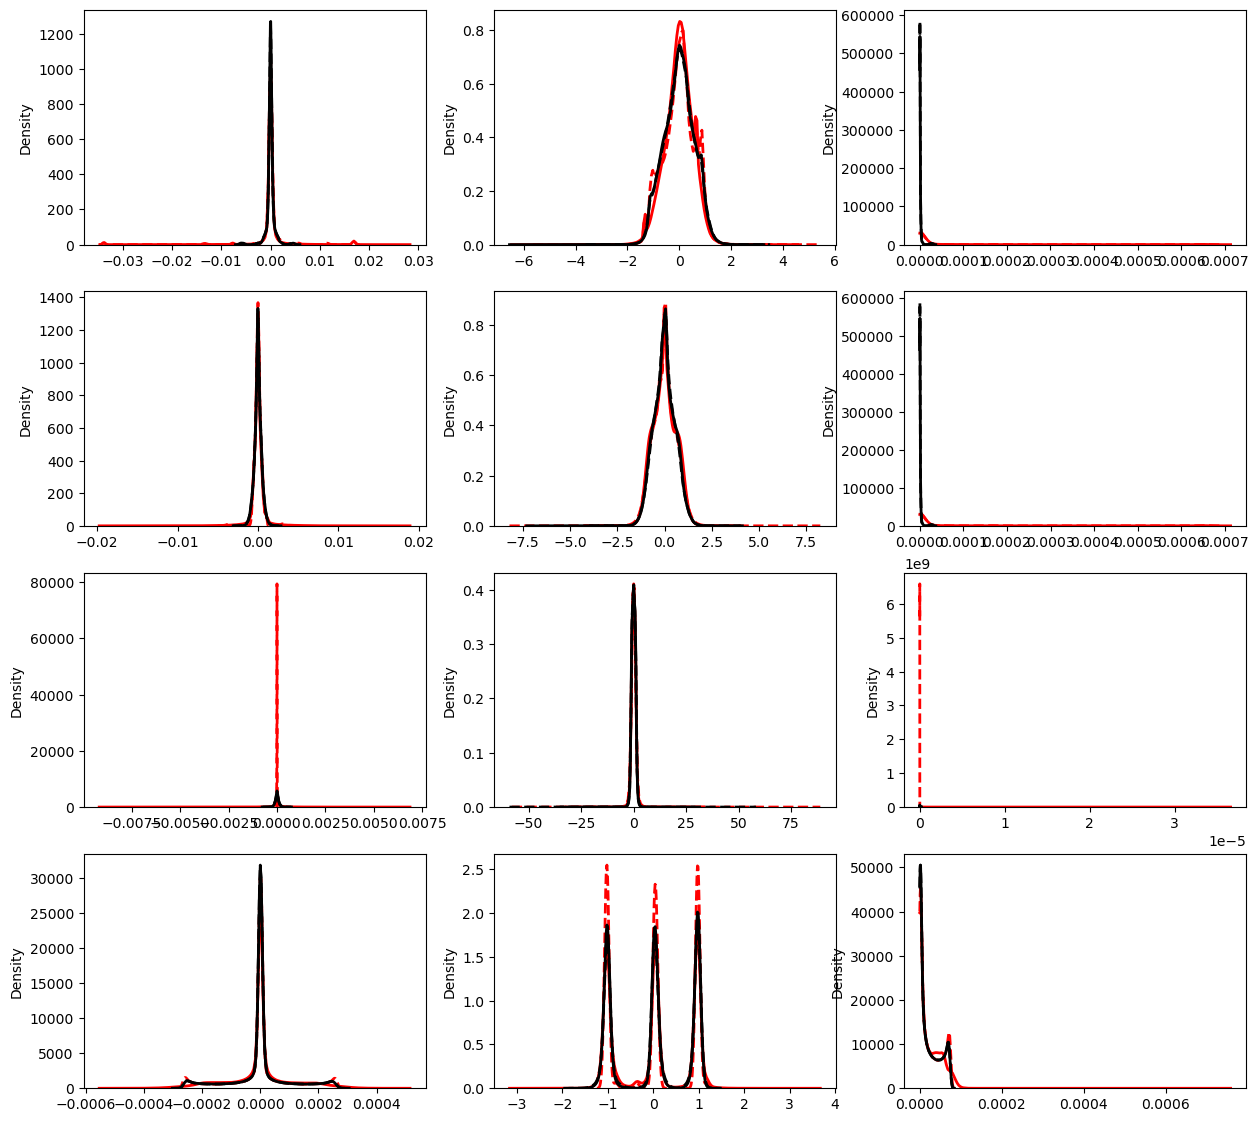

In [11]:
lw=2

fig1,ax1 = plt.subplots(4,3,figsize = (15,14))
varNames = [r"$u'$", r"$v'$", r"$w'$", r"$b'$"]
scaleNames = [r'$k$', r'$k_h$', r'$k_v$', r'$e_p$']
fileNames = ['LES 0 s','LES 700 s',r'$\overline{\text{DNS}}$ 0 s',r'$\overline{\text{DNS}}$ 700 s']
colors = ['r','r','k','k']
lineStys = ['--','-','--','-']

bwfactor=1
bins=100
for ivar in range(len(varNames)):
    for ifile in range(len(fileSplitInd)-1):
        
        #if ivar==3:
                #bwfactor=1#3*bwfactor

        sns.kdeplot(ax=ax1[ivar,0],data=xunscaled[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,color=colors[ifile],linestyle=lineStys[ifile],bw_adjust=bwfactor)
        sns.kdeplot(ax=ax1[ivar,1],   data=xlocal[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,color=colors[ifile],linestyle=lineStys[ifile],bw_adjust=bwfactor)
        
        clipping = [np.min([0,np.min(scales[:,ivar])]),None]
        sns.kdeplot(ax=ax1[ivar,2],   data=scales[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,color=colors[ifile],linestyle=lineStys[ifile],bw_adjust=bwfactor,clip=clipping)

        # ax1[ivar,0].hist(xunscaled[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')
        # ax1[ivar,1].hist(xlocal[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')
        # ax1[ivar,2].hist(scales[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')

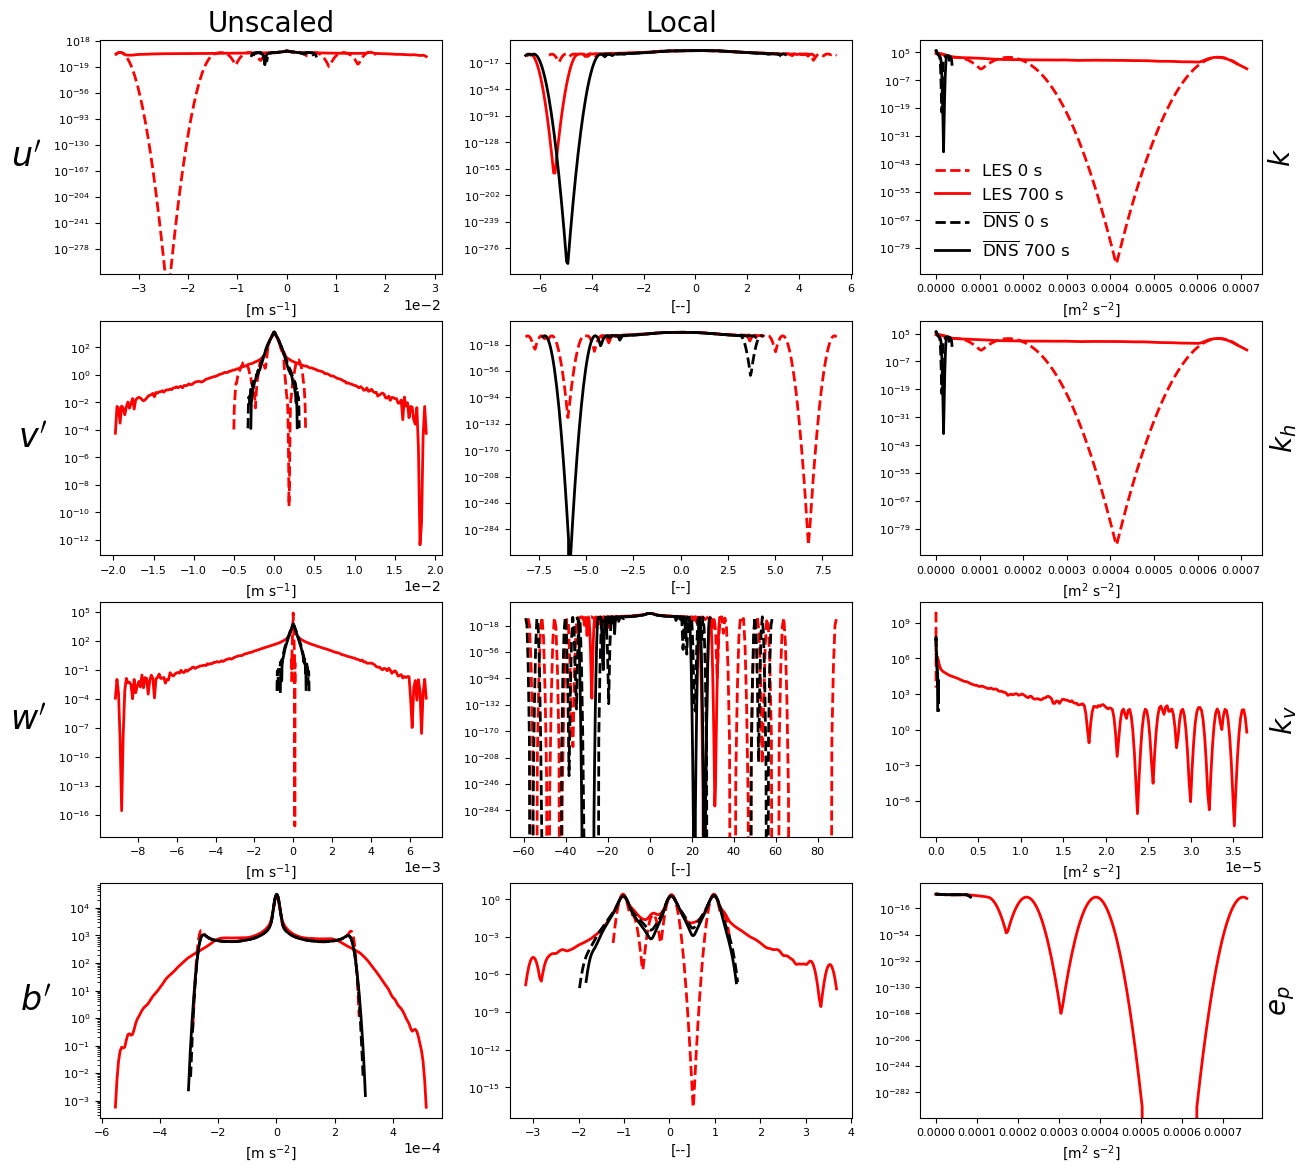

In [12]:
fs=20
ls=8
pad=0

xLabelsRaw=[r'[m s$^{-1}$]',r'[m s$^{-1}$]',r'[m s$^{-1}$]',r'[m s$^{-2}$]']
xLabelLocal=r'[--]'
xLabelScale=r'[m$^{2}$ s$^{-2}$]'

varNames = [r"$u'$", r"$v'$", r"$w'$", r"$b'$"]
for ivar in range(len(varNames)):
    
    ax1[ivar,0].annotate(varNames[ivar], xy=(0, 0.5), xytext=(-ax1[ivar,0].yaxis.labelpad - pad, 0),
        xycoords=ax1[ivar,0].yaxis.label, textcoords='offset points',
        size=24, ha='right', va='center')
        
    for sc in range(3):

        ax1[ivar,sc].set_yscale('log')
        ax1[ivar,sc].set_ylabel('')
        ax1[ivar,sc].tick_params(axis='y',labelsize=ls)
        ax1[ivar,sc].tick_params(axis='x',labelsize=ls)
        # ax1[ivar,sc].set_xlim(xLims[ivar][sc])
        # ax1[ivar,sc].set_ylim(yLims[ivar][sc])
    
    ax1[ivar,0].set_xlabel(xLabelsRaw[ivar])
    ax1[ivar,1].set_xlabel(xLabelLocal)
    ax1[ivar,2].set_xlabel(xLabelScale)

    ax1[ivar,-1].yaxis.set_label_position("right") 
    ax1[ivar,-1].set_ylabel(scaleNames[ivar],size=fs)
    ax1[ivar,0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))

ax1[0,0].set_title('Unscaled',size=fs)
#ax1[0,1].set_title('Statistical',size=fs)
#ax1[0,2].set_title('Global',size=fs)
ax1[0,1].set_title('Local',size=fs)
# handles, labels = ax1[0,-1].get_legend_handles_labels()
# new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
# ax1[0,1].legend(handles=new_handles, labels=labels)
ax1[0,2].legend(frameon=False,framealpha=0,fontsize=12)

#plt.figure(fig1)
#fmt="png"
#plt.savefig("compareScaledInputsAll_Re."+fmt, format=fmt)

fig1

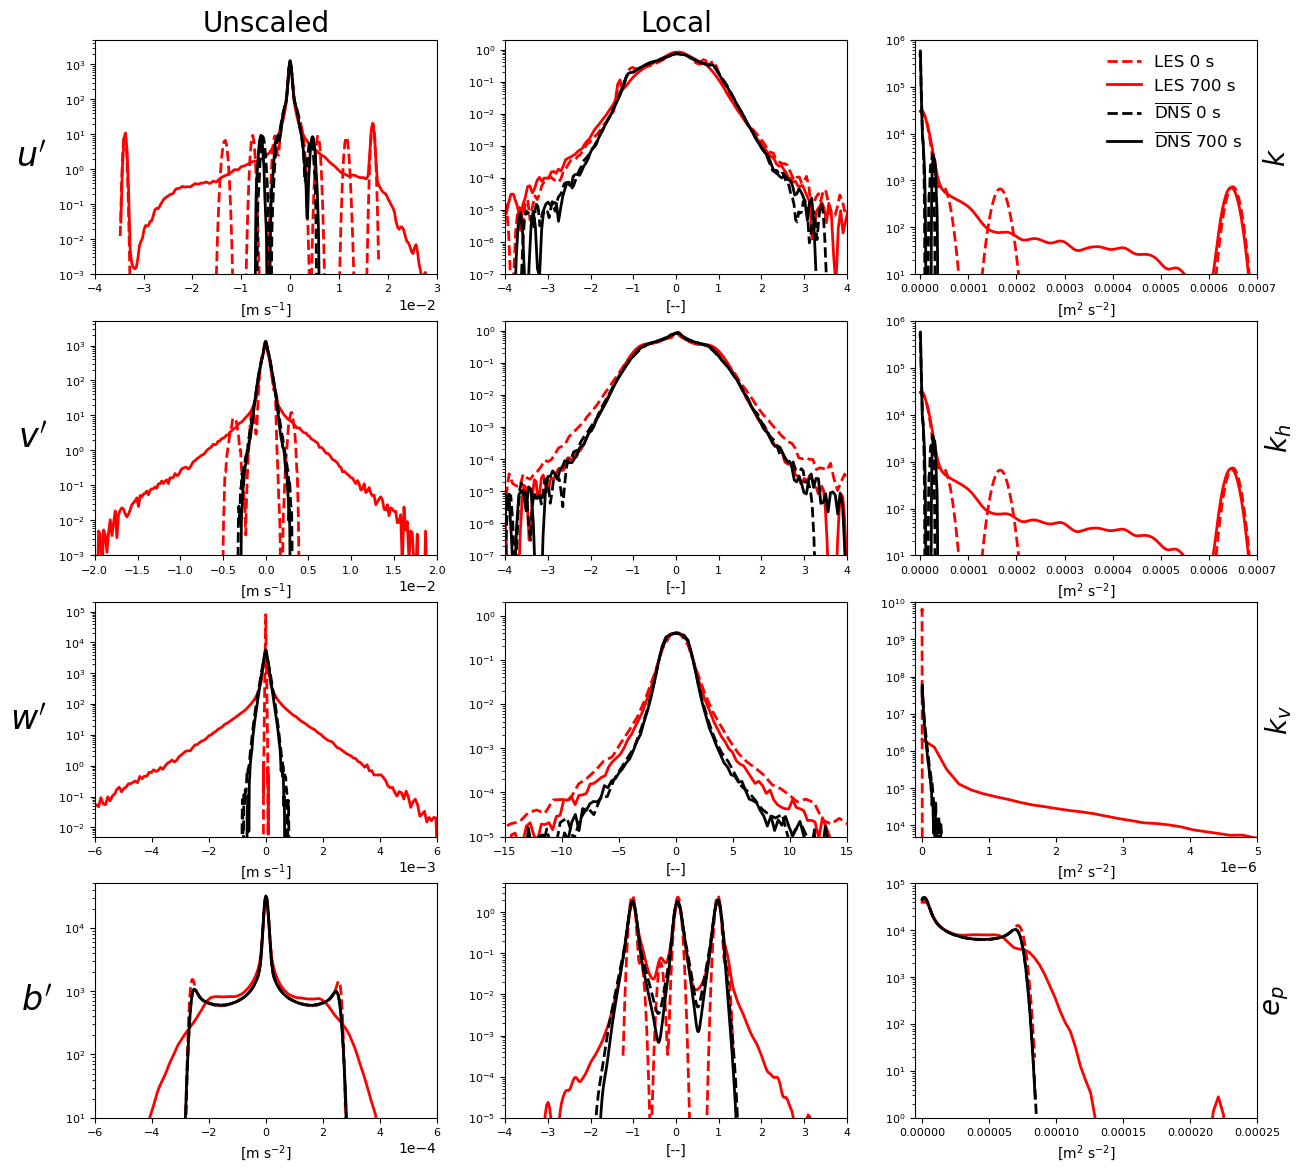

In [13]:
xLims=[[[-4e-2,3e-2],[-4,4],[-1e-5,7e-4]],
       [[-2e-2,2e-2],[-4,4],[-1e-5,7e-4]],#[-6e-3,6e-3]
       [[-6e-3,6e-3],[-15,15],[-1e-7,5e-6]],
       [[-6e-4,6e-4],[-4,4],[-5e-6,2.5e-4]]]

yLims=[[[1e-3,5e3],[1e-7,2e0],[1e1,1e6]],
       [[1e-3,5e3],[1e-7,2e0],[1e1,1e6]],
       [[5e-3,2e5],[1e-5,2e0],[5e3,1e10]],
       [[1e1,5e4],[1e-5,5e0],[1e0,1e5]]]


for ivar in range(len(ax1)):
    for sc in range(len(ax1[0])):

        ax1[ivar,sc].set_xlim(xLims[ivar][sc])
        ax1[ivar,sc].set_ylim(yLims[ivar][sc])
   
fig1

In [14]:
plt.figure(fig1)
fmt="eps"
plt.savefig("Distributions_onVsOffline_ReInterp_inputs."+fmt, format=fmt)

/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/glade/work/adac/conda-envs/e2cnn/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

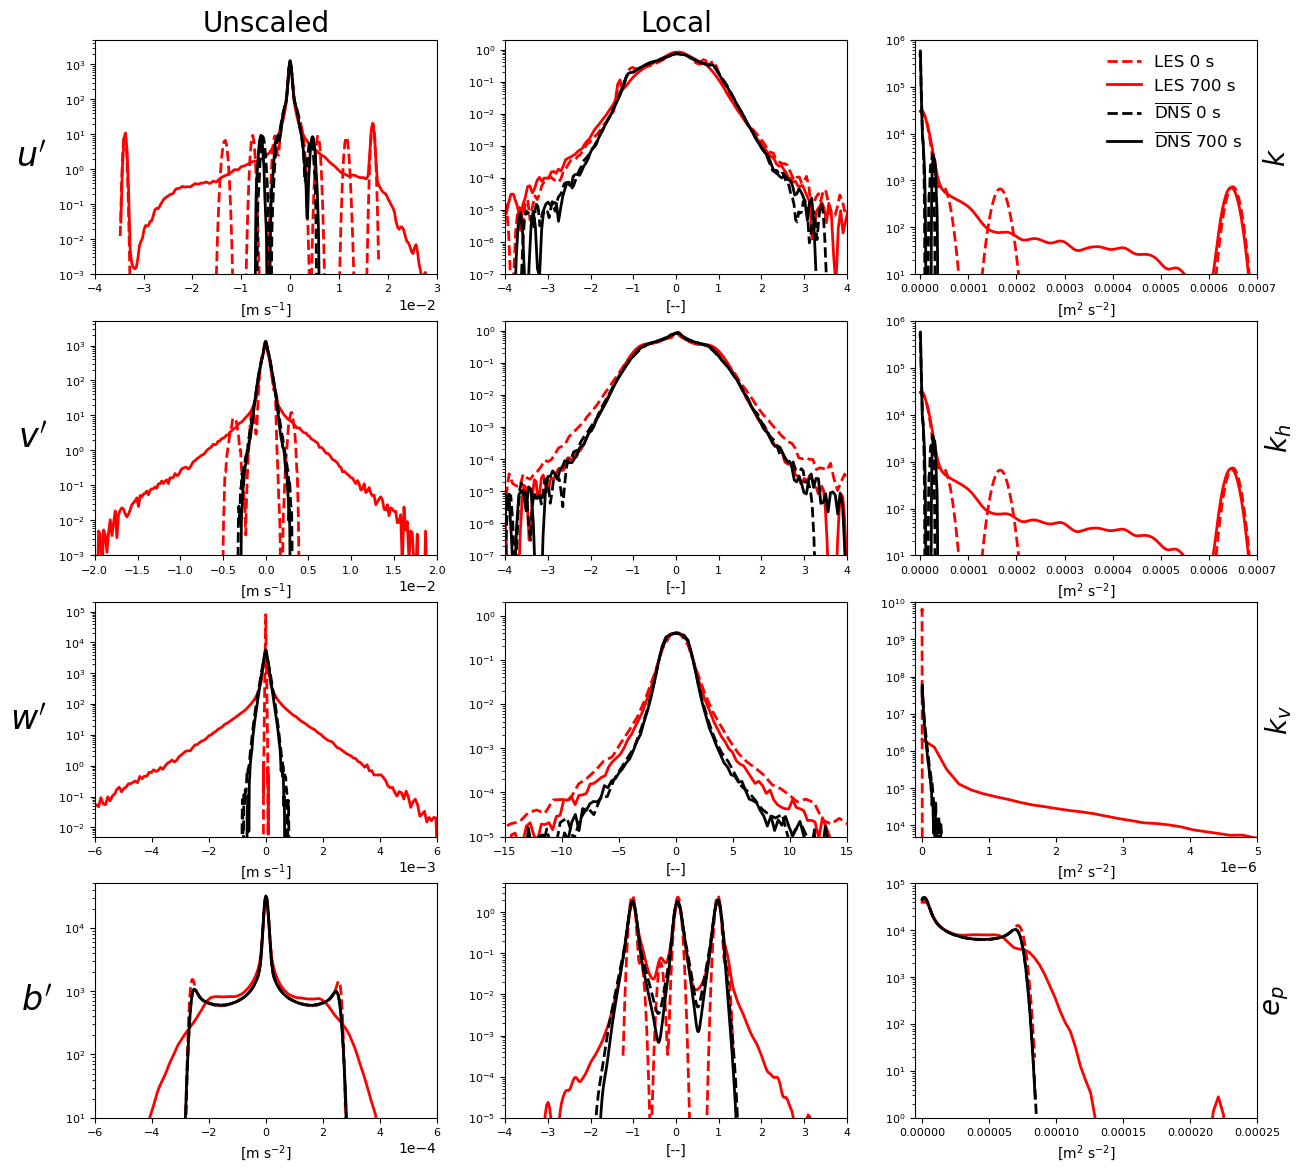

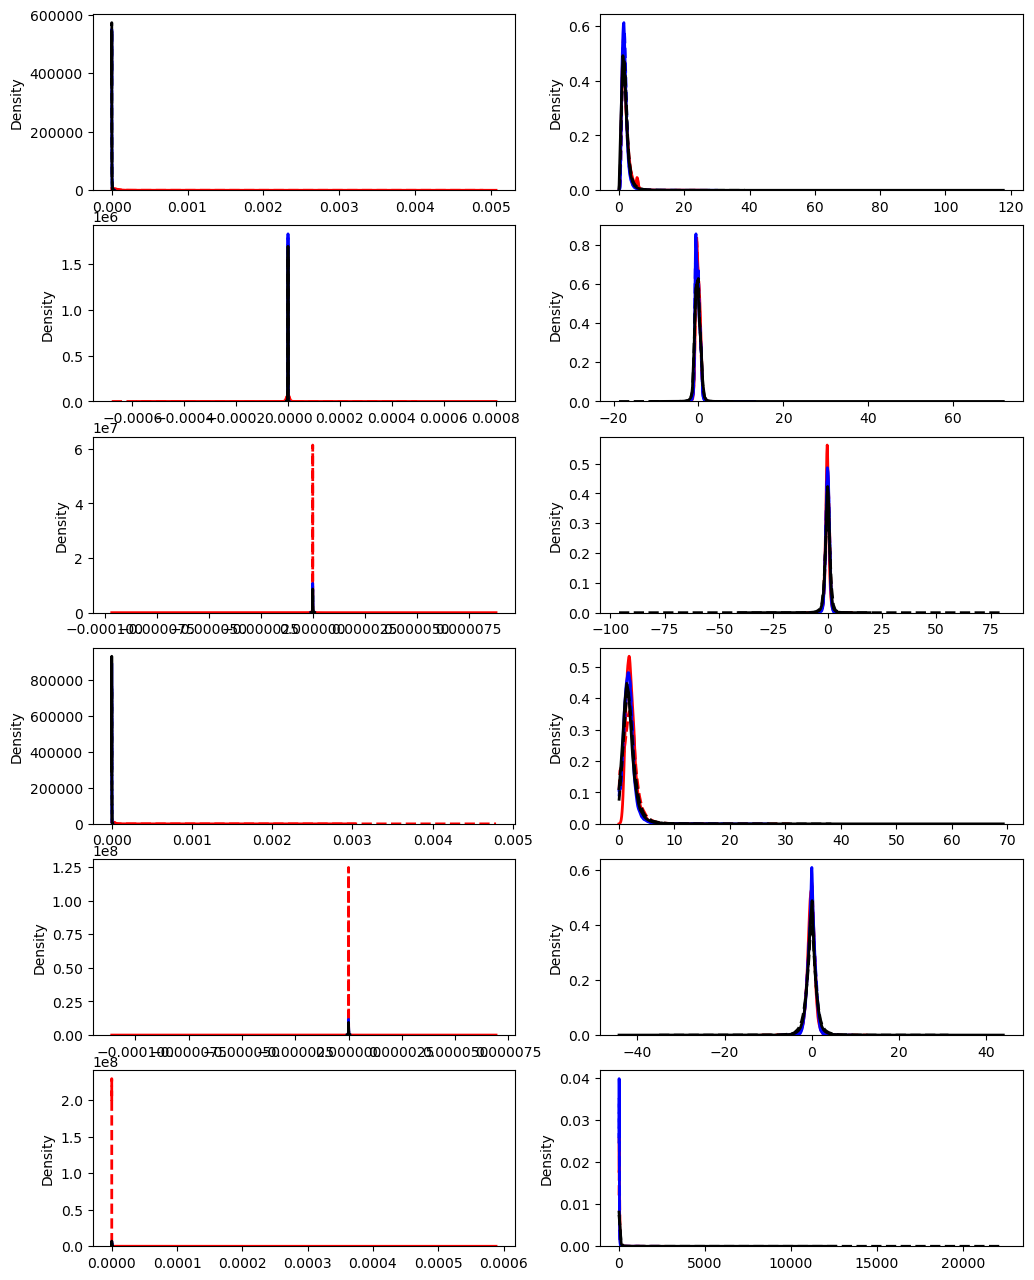

In [15]:
lw=2

fig0,ax0 = plt.subplots(6,2,figsize = (12,16))
varNames = [r'$\tau_{11}$', r'$\tau_{12}$', r'$\tau_{13}$', r'$\tau_{22}$', r'$\tau_{23}$', r'$\tau_{33}$']
rawNames = [r'$y^{\text{scale}}_{\text{LES}}$DNN($x^*_{\text{LES}}$) 0 s',r'$y^{\text{scale}}_{\text{LES}}$DNN($x^*_{\text{LES}}$) 700 s',r'$y^{\text{scale}}_{\text{DNS}}$DNN($x^*_{\text{DNS}}$) 0 s',r'$y^{\text{scale}}_{\text{DNS}}$DNN($x^*_{\text{DNS}}$) 700 s',r'$y_{\text{DNS}}$ 0 s',r'$y_{\text{DNS}}$ 700 s']
localNames = [r'DNN($x^*_{\text{LES}}$) 0 s',r'DNN($x^*_{\text{LES}}$) 700 s',r'DNN($x^*_{\text{DNS}}$) 0 s',r'DNN($x^*_{\text{DNS}}$) 700 s',r'$y^*_{\text{DNS}}$ 0 s',r'$y^*_{\text{DNS}}$ 700 s']#r'$y_{\text{DNS}}/y^{\text{scale}}_{\text{DNS}}$ 1000 s']
colors = ['r','r','b','b']
lineStys = ['--','-','--','-']

bwfactor=1
for ivar in range(len(varNames)):
    
    if ivar==0 or ivar==3 or ivar==5:
        clipping = [0,None]
        if ivar==5:
            bwfactor=3*bwfactor
    else:
        clipping = [None,None]
        
    for ifile in range(len(fileSplitInd)-1):
        sns.kdeplot(ax=ax0[ivar,0], data=y_dim[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar],label=rawNames[ifile],linewidth=lw,color=colors[ifile],linestyle=lineStys[ifile],clip=clipping,bw_adjust=bwfactor)
        # sns.kdeplot(ax=ax0[ivar,1],   data=ystats[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar],label=fileNames[ifile],linewidth=lw,clip=clipping)
        # sns.kdeplot(ax=ax0[ivar,2],  data=yglobal[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar],label=fileNames[ifile],linewidth=lw,clip=clipping)
        sns.kdeplot(ax=ax0[ivar,1],   data=y_pred[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar],label=localNames[ifile],linewidth=lw,color=colors[ifile],linestyle=lineStys[ifile],clip=clipping,bw_adjust=bwfactor)

    for ifile in range(ifileDNSstart,len(fileSplitInd)-1):
        sns.kdeplot(ax=ax0[ivar,1],   data=ylocal[fileSplitInd[ifile]-DNSstartInd:fileSplitInd[ifile+1]-DNSstartInd,ivar],label=localNames[ifile+ifileDNSstart],linewidth=lw,color='k',linestyle=lineStys[ifile],clip=clipping,bw_adjust=bwfactor)
        sns.kdeplot(ax=ax0[ivar,0],   data=yunscaled[fileSplitInd[ifile]-DNSstartInd:fileSplitInd[ifile+1]-DNSstartInd,ivar],label=rawNames[ifile+ifileDNSstart],linewidth=lw,color='k',linestyle=lineStys[ifile],clip=clipping,bw_adjust=bwfactor)


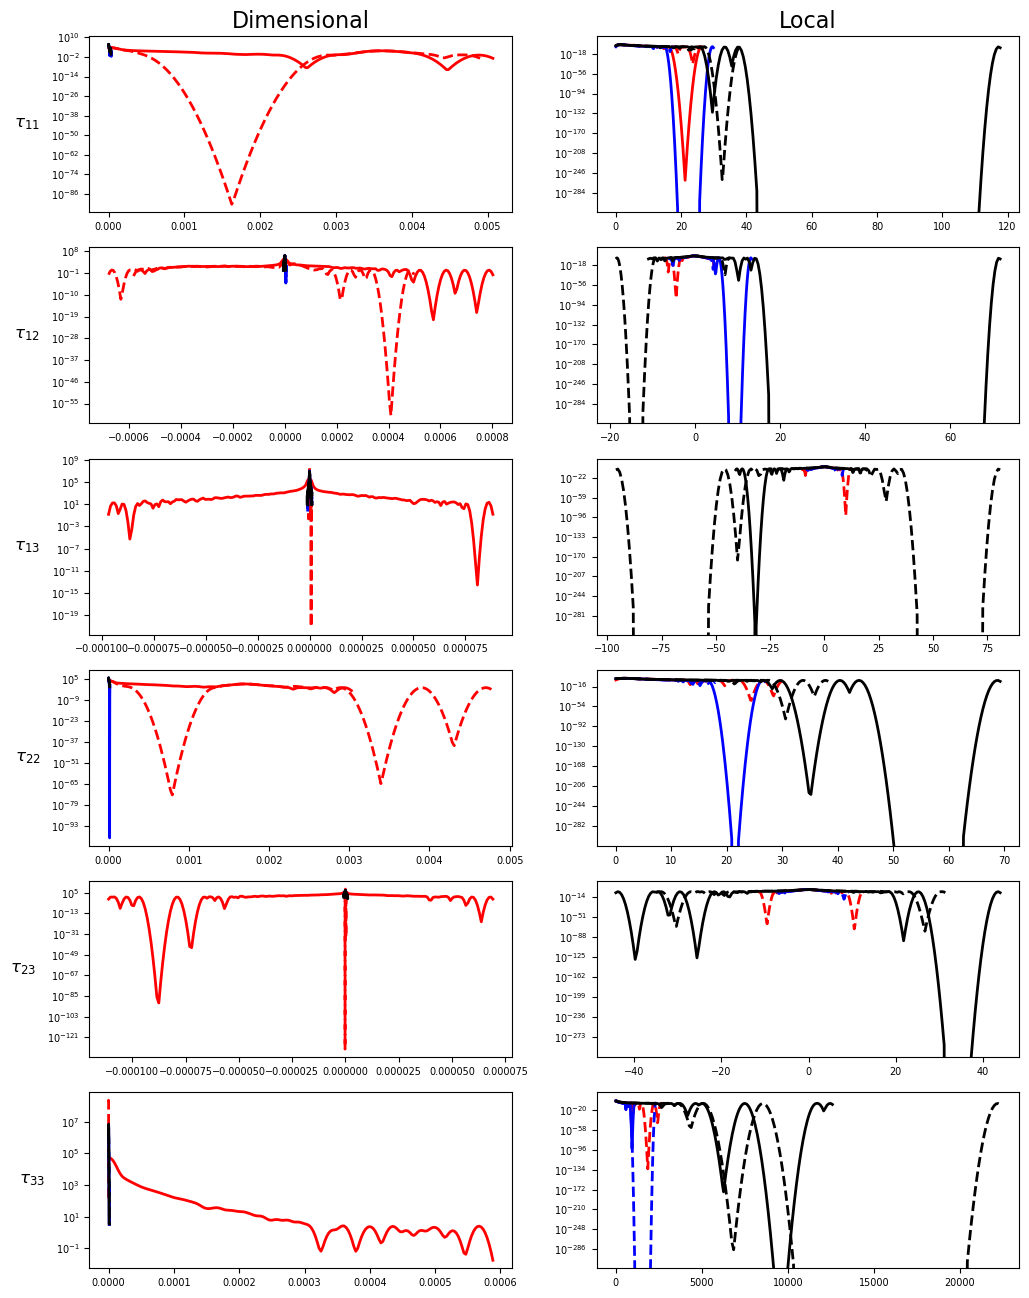

In [16]:
fs=16
ls=7
pad=0

xLabelsRaw=[r'[m s$^{-1}$]',r'[m s$^{-1}$]',r'[m s$^{-1}$]',r'[m s$^{-2}$]']
xLabelLocal=r'[--]'

varNames = [r'$\tau_{11}$', r'$\tau_{12}$', r'$\tau_{13}$', r'$\tau_{22}$', r'$\tau_{23}$', r'$\tau_{33}$']
for ivar in range(len(varNames)):
    
    ax0[ivar,0].annotate(varNames[ivar], xy=(0, 0.5), xytext=(-ax0[ivar,0].yaxis.labelpad - pad, 0),
                    xycoords=ax0[ivar,0].yaxis.label, textcoords='offset points',
                    size=12, ha='right', va='center')
    
    for sc in range(2):
        ax0[ivar,sc].set_yscale('log')
        ax0[ivar,sc].set_ylabel('')
        ax0[ivar,sc].tick_params(axis='y',labelsize=ls)
        ax0[ivar,sc].tick_params(axis='x',labelsize=ls)
        #if ivar==0 or ivar==3 or ivar==5:
            #ax0[ivar,sc].set_xscale('log')
        # ax0[ivar,sc].set_xlim(xLims[ivar][sc])
        # ax0[ivar,sc].set_ylim(yLims[ivar][sc])
        #ax0[ivar,sc].ticklabel_format(axis='x',style='sci')

ax0[0,0].set_title('Dimensional',size=fs)
# ax0[0,1].set_title('Statistical',size=fs)
# ax0[0,2].set_title('Global',size=fs)
ax0[0,1].set_title('Local',size=fs)
# handles, labels = ax0[0,-1].get_legend_handles_labels()
# new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

fig0

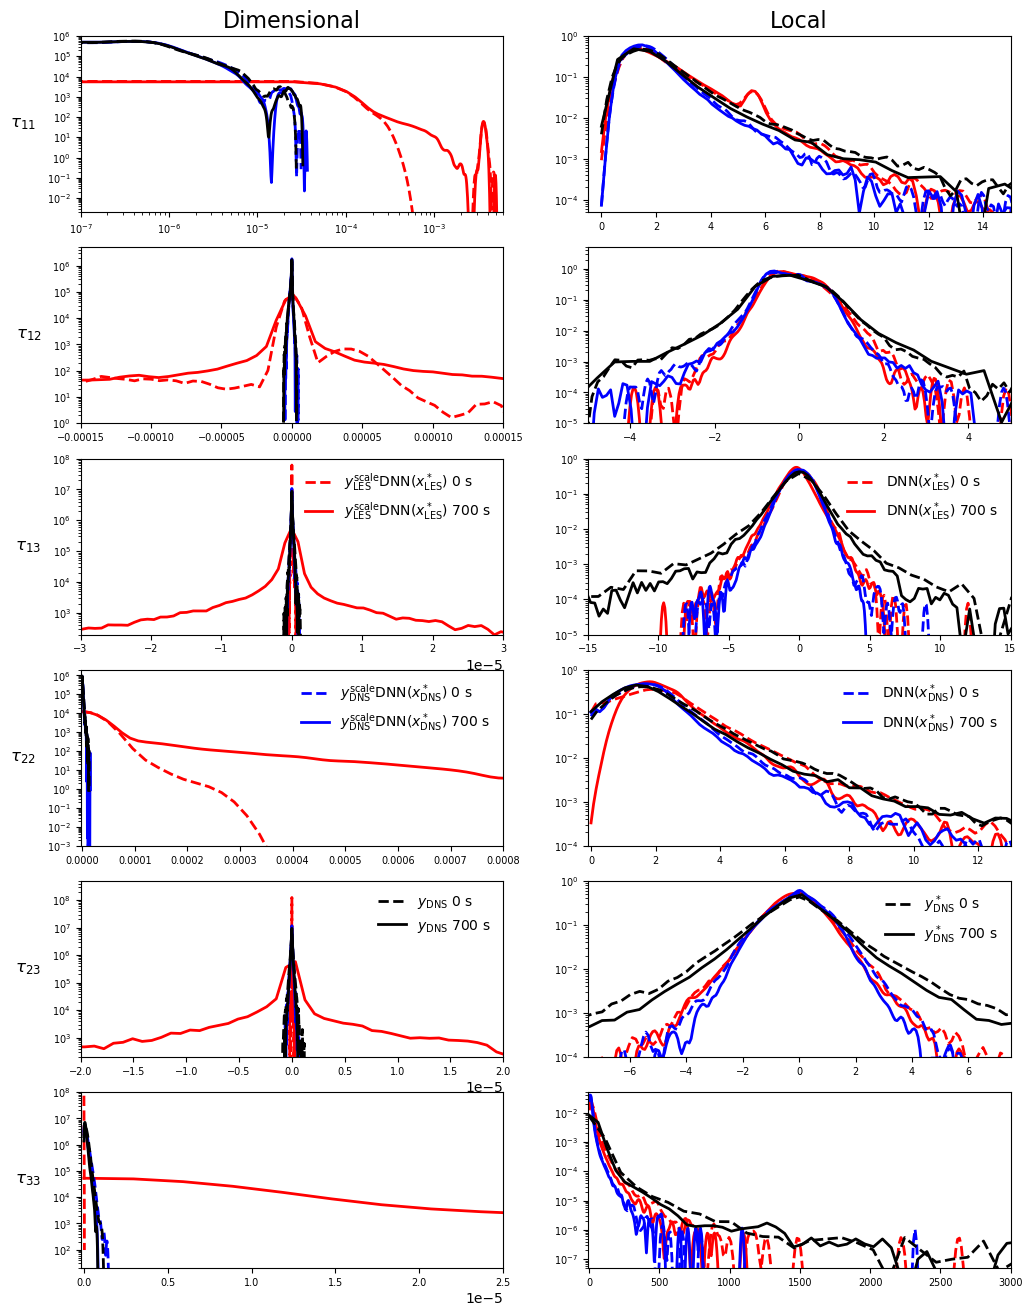

In [17]:
xLims=[[[1e-7,6e-3],[-.5,15]],#-5e-6
       [[-1.5e-4,1.5e-4],[-5,5]],
       [[-3e-5,3e-5],[-15,15]],
       [[-3e-6,8e-4],[-.1,13]],
       [[-2e-5,2e-5],[-7.5,7.5]], #[-2e-6,2e-6]
       [[-2e-7,2.5e-5],[-10,3e3]]]

yLims=[[[2e-3,1e6],[5e-5,1e0]],
       [[1e0,5e6],[1e-5,5e0]],
       [[2e2,1e8],[1e-5,1e0]],
       [[1e-3,2e6],[1e-4,1e0]],
       [[2e2,5e8],[1e-4,1e0]],
       [[2e1,1e8],[5e-8,5e-2]]]

xLogInd=[0]

varNames = [r'$\tau_{11}$', r'$\tau_{12}$', r'$\tau_{13}$', r'$\tau_{22}$', r'$\tau_{23}$', r'$\tau_{33}$']
for ivar in range(len(varNames)):
    
    if ivar in xLogInd:
        ax0[ivar,0].set_xscale('log')
    
    for sc in range(2):            
        ax0[ivar,sc].set_xlim(xLims[ivar][sc])
        ax0[ivar,sc].set_ylim(yLims[ivar][sc])
        #ax0[ivar,sc].ticklabel_format(axis='x',style='sci')


for i in range(ax0.shape[1]):
    handles,labels=ax0[0,i].get_legend_handles_labels()
    nLabel=len(labels)
    ax0[2,i].legend(ncol=1,handles=handles[:int(nLabel/3)],frameon=False,fontsize=10)
    ax0[3,i].legend(ncol=1,handles=handles[int(nLabel/3):int(2*nLabel/3)],frameon=False,fontsize=10)
    ax0[4,i].legend(ncol=1,handles=handles[int(2*nLabel/3):],frameon=False,fontsize=10)

fig0

In [18]:
plt.figure(fig0)
fmt="eps"
plt.savefig("Distributions_onVsOffline_ReInterp_outputs."+fmt, format=fmt)